<a href="https://colab.research.google.com/github/Henry-0810/Artificial-Intelligence/blob/main/portfolio_optimization_ga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Genetic Algorithm**
## **Portfolio Optimization**
I will only use 5 stocks for this project. Stock data are all real-time, retrived from the Yahoo Finance API, https://pypi.org/project/yfinance/

## Problem Statement (~30%)

### Description of the Problem  
Portfolio optimization is the process of selecting the best combination of assets to maximize returns while minimizing risk. A common approach is **Markowitz’s Mean-Variance Optimization (MVO)**, which constructs an efficient portfolio using expected returns, variances, and covariances of assets.  

However, MVO has several limitations:  
1. **Complexity**: Solving quadratic optimization problems becomes expensive as the number of assets grows.  
2. **Strict Assumptions**: MVO assumes asset returns follow a normal distribution and that investors have quadratic utility functions, which is not always realistic.  
3. **Handling Constraints**: Incorporating real-world constraints (e.g., restricting allocations to certain stocks) increases the complexity.  

To overcome these challenges, this project applies a **Genetic Algorithm (GA)** to optimize portfolio allocation. Unlike MVO, GA is a heuristic approach that efficiently searches for near-optimal solutions without relying on strict mathematical assumptions.  

The goal is to maximize the **Sharpe Ratio**, a key financial metric that balances return and risk, making GA a suitable technique for solving this problem.

---

### Discussion of the Suitability of Genetic Algorithms
Genetic Algorithms (GAs) are well-suited for portfolio optimization due to their ability to handle large search spaces and complex constraints. Key advantages include:  

- **Scalability** – GAs can handle large datasets efficiently without exponential growth in computational cost.  
- **No Assumption of Normality** – Unlike MVO, GA does not require asset returns to be normally distributed.  
- **Flexibility** – GA can incorporate additional constraints, such as limiting investment in specific stocks or ensuring minimum allocation to certain sectors.  

Through **evolutionary selection**, GA gradually improves the portfolio allocation, leading to **higher Sharpe Ratios** compared to naive allocation strategies.

---

### Complexity of the Problem (Project Plan)
Portfolio optimization presents a **high-dimensional, non-linear problem** where:  
- Each chromosome represents a possible portfolio allocation (weights og assets).  
- The solution space grows exponentially with the number of stocks considered.  
- Evaluating a portfolio requires calculating historical **returns, variances, and covariances** over a defined period.  
- The GA must balance exploration (mutation) and exploitation (crossover) to meet an optimal solution efficiently.  

The complexity of the Genetic Algorithm increases with:  
- The **number of assets** included in the portfolio (will be using only 5 in this case for a proof of concept).  
- The **historical data period** used for return calculations (longer periods increase computational load).  
- The **GA parameters** (population size, mutation rate, number of generations), which impact convergence speed.  

Despite this complexity, GA provides a robust and adaptable approach to solving portfolio optimization problems where traditional methods struggle.

---

**Reference**  
- [Markowitz Portfolio Theory](https://sites.math.washington.edu/~burke/crs/408/fin-proj/mark1.pdf)


## The Problem and Fitness Function (~20%)

In [170]:
import pandas as pd
import numpy as np
import yfinance as yf
from google.colab import drive
import matplotlib.pyplot as plt

#### 1. Fetch Historical Data
I will fetch 10 years of historical data starting from February 11th 2014 to February 11th 2025.
I will investigate on 5 Stocks:
1. Apple Inc. (AAPL)
2. Tesla Inc. (TSLA)
3. Microsoft Corp. (MSFT)
4. Amazon.com Inc. (AMZN)
5. NVIDIA Corporation (NVDA)

In [171]:
# start_date = "2020-02-11"
start_date = "2014-02-11"
end_date = "2025-02-11"

stocks = ["AAPL","TSLA","MSFT","AMZN","NVDA"]

# Added 5 more stocks that are not tech related to increase diversity, stocks 1st version result in poor Sharpe Ratio due to same type/industry of stocks
stocks_2nd_version = ["AAPL", "TSLA", "MSFT", "AMZN", "NVDA", "JNJ", "XOM", "KO", "WMT", "V"]

data = yf.download(stocks, start=start_date, end=end_date, interval="1d")
data_10 = yf.download(stocks_2nd_version, start=start_date, end=end_date, interval="1d")
print("\n", data.columns)


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  10 of 10 completed


 MultiIndex([( 'Close', 'AAPL'),
            ( 'Close', 'AMZN'),
            ( 'Close', 'MSFT'),
            ( 'Close', 'NVDA'),
            ( 'Close', 'TSLA'),
            (  'High', 'AAPL'),
            (  'High', 'AMZN'),
            (  'High', 'MSFT'),
            (  'High', 'NVDA'),
            (  'High', 'TSLA'),
            (   'Low', 'AAPL'),
            (   'Low', 'AMZN'),
            (   'Low', 'MSFT'),
            (   'Low', 'NVDA'),
            (   'Low', 'TSLA'),
            (  'Open', 'AAPL'),
            (  'Open', 'AMZN'),
            (  'Open', 'MSFT'),
            (  'Open', 'NVDA'),
            (  'Open', 'TSLA'),
            ('Volume', 'AAPL'),
            ('Volume', 'AMZN'),
            ('Volume', 'MSFT'),
            ('Volume', 'NVDA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])


There are 5 types of Prices: Close, High, Low, Open, Volume. Close prices are often used for analysis because it reflects the final consensus on the stock price for the trading day. It is often most consistent for portfolio optimization.

In [172]:
close_data = data["Close"]
close_data_10 = data_10["Close"]
drive.mount('/content/drive')

close_data.to_csv('/content/drive/My Drive/stock_data.csv')
close_data_10.to_csv('/content/drive/My Drive/stock_data_10.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [173]:
stock_data = pd.read_csv('/content/drive/My Drive/stock_data.csv', index_col=0, parse_dates=True)
stock_data_10 = pd.read_csv('/content/drive/My Drive/stock_data_10.csv', index_col=0, parse_dates=True)
stock_data.head(10)

,AAPL,AMZN,MSFT,NVDA,TSLA
Date,,,,,
2014-02-11,16.780828,18.089500,31.004759,0.383127,13.108000
2014-02-12,16.779570,17.462500,31.254999,0.396802,13.021333
2014-02-13,17.046028,17.860001,31.371775,0.409297,13.308667
2014-02-14,17.032240,17.867500,31.380116,0.422265,13.215333
2014-02-18,17.094870,17.682501,31.447340,0.422029,13.580000
2014-02-19,16.824978,17.368999,31.522980,0.427688,12.909333
2014-02-20,16.630228,17.490000,31.724670,0.442777,13.998000
2014-02-21,16.445503,17.337999,31.917953,0.439476,13.973333
2014-02-24,16.517508,17.589001,31.674261,0.445842,14.510000


#### 2. Preprocess Data (Compute Returns and Risk)

Before defining the fitness function **(Sharpe Ratio)**, I need to compute some key financial metrics from the historical stock data.

Portfolio optimization requires **2** fundamental components:
1. Returns → Measures how an asset appreciates over time
2. Risk (Standard Deviation & Covariance) → Measures relationship between assets

To Calculate returns and risk, **3** statistical methods are used:
- Daily Returns: estimate expected return of portfolio
- Covariance Matrix: measure risk relationship between different stocks
- Standard Deviation: quantify portfolio risk

Without calculating these, Sharpe Ratio cannot be correctly evaluated.

In [174]:
daily_returns = stock_data.pct_change().dropna()

# multiplying 252 because 1 year have 252 working days
expected_returns = daily_returns.mean() * 252

covariance_matrix = daily_returns.cov() * 252

print("Daily Return:\n",daily_returns)
print("\nExpected Return:\n", expected_returns)
print("\nCovariance Matrix:\n", covariance_matrix)

Daily Return:
                 AAPL      AMZN      MSFT      NVDA      TSLA
Date                                                        
2014-02-12 -0.000075 -0.034661  0.008071  0.035692 -0.006612
2014-02-13  0.015880  0.022763  0.003736  0.031491  0.022066
2014-02-14 -0.000809  0.000420  0.000266  0.031682 -0.007013
2014-02-18  0.003677 -0.010354  0.002142 -0.000558  0.027594
2014-02-19 -0.015788 -0.017729  0.002405  0.013408 -0.049386
...              ...       ...       ...       ...       ...
2025-02-04  0.021008  0.019543  0.003529  0.017058  0.022232
2025-02-05 -0.001418 -0.024333  0.002231  0.052086 -0.035797
2025-02-06  0.003226  0.011263  0.006122  0.030842 -0.010181
2025-02-07 -0.023969 -0.040531 -0.014598  0.009015 -0.033928
2025-02-10  0.001187  0.017412  0.006028  0.028728 -0.030114

[2766 rows x 5 columns]

Expected Return:
 AAPL    0.276566
AMZN    0.285809
MSFT    0.270833
NVDA    0.645632
TSLA    0.457405
dtype: float64

Covariance Matrix:
           AAPL      AMZN   

#### **Observation**

Expected Returns:
- TSLA (0.005521) has the highest expected return, indicating strong growth potential but also higher risk.
- AMZN (0.002860) and NVDA (0.002209) follow, suggesting moderate expected returns.
- AAPL (0.000475) and MSFT (0.000236) have the lowest expected returns, implying more stability.

Covariance Matrix:
- TSLA and NVDA show the highest variances, indicating greater price fluctuations.
- AMZN is moderately correlated with NVDA and TSLA, potentially indicating similar market influences.
- AAPL and MSFT have lower variances, reinforcing their status as more stable assets.
---
**Reference**:
- Markowitz, H. (1952). *Portfolio Selection.* The Journal of Finance, 7(1), 77-91. DOI: [10.2307/2975974](https://doi.org/10.2307/2975974)

#### 3. Sharpe Ratio - Fitness Function
**Introduction of Sharpe Ratio** <br>
The fitness function in my Genetic Algorithm is the **Sharpe Ratio**, a key financial metric that measures risk-adjusted return. <br>
Formulas below:
\begin{aligned}
S &= \frac{E(R_p) - R_f}{\sigma_p}
\end{aligned}

where:  
- $S$ = Sharpe Ratio  
- $E(R_p)$ = Expected portfolio return  
- $R_f$ = Risk-free rate (Since the portfolio consists only 5 stocks and does not include a risk-free asset like government bonds, assuming 0 simplifies calculations without affecting the optimization objective.)  
- $\sigma_p$ = Portfolio standard deviation (risk)  

\begin{aligned}
E(R_p) = \sum_{i=1}^{N} w_i E(R_i)
\end{aligned}

where:
- $w_i$ = weight of stock $i$
- $R_i$ = return of stock $i$


The Sharpe Ratio is widely used in finance because it provides a balanced measure of risk vs. return. Unlike simple return-based metrics, it penalizes high volatility, ensuring that we optimize portfolios that offer steady and reliable returns.

---

**Why use Sharpe Ratio as a Fitness Function?**
1. Risk-Adjusted Performance: Ensures GA selects portfolios that maximize return while controlling risk.  
2. Industry Standard Metric: Used by hedge funds and investment firms for portfolio evaluation.  
3. Handles Different Market Conditions: Works well in both volatile and stable markets.  

By using Genetic Algorithms, we evolve portfolios that maximize the Sharpe Ratio, leading to an optimal allocation of assets that achieves the best trade-off between *profitability and risk*.

---

**Reference:**  
- Sharpe, W. F. (1966). "Mutual Fund Performance". *Journal of Business*, 39(1), 119-138. ([JSTOR](https://www.jstor.org/stable/2351741))  

In [175]:
def sharpe_ratio(weights, expected_returns, covariance_matrix, risk_free_rate=0.4):
  """
  Parameters:
  - weights: Array of portfolio allocation (sum to 1)
  - expected_returns: Expected return of each stocks
  - covariance_matrix: Covariance matrix of stock returns
  - risk_free_rates: default = 0

  Returns:
  - Sharpe Ratio (higher = better/optimized)
  """

  # Reference to Sharpe Ratio formulas above
  portfolio_return = np.dot(weights, expected_returns)

  # Transpose weights to get a single variance value
  portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix * 252, weights))
  portfolio_stddev = np.sqrt(portfolio_variance)

  return (portfolio_return - risk_free_rate) / portfolio_stddev

In [176]:
def penalized_sharpe(weights, expected_returns, covariance_matrix, risk_free_rate=0.04):
    sr = sharpe_ratio(weights, expected_returns, covariance_matrix, risk_free_rate)

    # Penalize sparse portfolios (less than 5 non-zero weights)
    num_assets_used = np.sum(weights > 0.05)
    if num_assets_used < 5:
        return sr - 0.1 * (5 - num_assets_used)  # penalize sparsity

    return sr

Testing Fitness Function

In [177]:
test_expected_return = np.array([0.12, 0.08, 0.10])
test_covariance_matrix = np.array([
    [0.04, 0.01, 0.02],
    [0.01, 0.03, 0.015],
    [0.02, 0.015, 0.05]
])

test_weights = np.array([0.4, 0.3, 0.4])

sharpe_value = sharpe_ratio(test_weights, test_expected_return, test_covariance_matrix)

print("Sharpe Ratio", sharpe_value)

Sharpe Ratio -0.10562852355255876


### Problem Class

In [178]:
class Problem:
  def __init__(self) -> None:
    self.number_of_genes = 5 #10 for GA Loop 3
    self.min_value = 0
    self.max_value = 1
    self.fitness_function = lambda weights: penalized_sharpe(weights, expected_returns, covariance_matrix)
    self.acceptable_fitness = 1 # < 1 = weak (but show stability), 1 - 1.5 = performing alright, > 1.5 = strong (at the same time risky)

## The Individual (~30%) - Defining the Genetic Algorithm Components

### Individual Components
#### Chromosome Representation
In this project, each chromosome represents a portfolio allocation, where genes are the weights of individual stocks in the portfolio. Each chromosome is an array of floating-point numbers summing up to 1.

For example: a chromosome might look like:
*\[0.25, 0.15, 0.30, 0.10, 0.20\]*

Why this representation? <br>
- Ensures a valid portfolio allocation without needing extra constraints.  
- Allows easy evaluation using the Sharpe Ratio as the fitness function.  
- Works naturally with crossover and mutation without breaking feasibility.  


These weights involve over generations to maximize the Sharpe Ratio.

---

#### Crossover (Recombination of Portfolios)
Crossover allows 2 parent portfolios to combine, creating a new portfolio that inherits some traits from both.

**Approach**
- Linear Interpolation Crossover: This method ensures that the child portfolios always sum to 1, maintaining valid asset allocation without perfoming normalization.

Justification of crossover approach: <br>
- Always maintains valid weights (sum = 1) without extra renormalization.  
- Encourages genetic diversity by allowing more flexible exploration.  
- Works better for constrained problems like portfolio allocation compared to traditional crossover (e.g., BLX crossover, which requires post-normalization).  

---

#### Mutation
Mutation helps prevent the GA from converging too quickly to a local optimum. We apply small random adjustments to portfolio weights.

**Approach**: Small Weight Perturbation with Renormalization
1. A small noise is added to randomly selected weights.  
2. Weights are clipped to prevent negative values (ensuring no short-selling).  
3. The portfolio is renormalized to maintain a total weight sum of 1.

Justification of mutation method: <br>
- Ensures that the weights always sum to 1 after mutation.  
- Prevents negative weights, ensuring all assets have a valid allocation.  
- Controlled noise to adjust weights without drastic changes.

This ensures mutation improves the solution without breaking constraints.

In [179]:
from copy import deepcopy

class PortfolioIndividual:
  def __init__(self, prob):
    """
    Initializes an individual portfolio (chromosomes)

    Parameters:
    - prob: An Instance of the Problem class
    """
    self.chromosomes = np.random.dirichlet(np.ones(prob.number_of_genes), size=1)[0]
    # normalize to 1
    self.chromosomes /= np.sum(self.chromosomes)
    self.fitness_function = prob.fitness_function
    self.fitness = self.fitness_function(self.chromosomes)

  def crossover(self, parent2, explore_crossover=0.1):
    """
    Linear Interpolation Crossover, more details above

    Parameters:
    - parent2: Another PortfolioIndividual to crossover with
    - explore_crossover: Exploration factor (default 0.1)

    Returns:
    - 2 children PortfolioIndividuals
    """
    alpha = np.random.uniform(-explore_crossover, 1 + explore_crossover)

    child1 = deepcopy(self)
    child2 = deepcopy(parent2)

    child1.chromosomes = alpha * self.chromosomes + (1 - alpha) * parent2.chromosomes
    child2.chromosomes = alpha * parent2.chromosomes + (1 - alpha) * self.chromosomes

    return child1, child2

  def mutate(self, mutation_rate=0.1, mutation_strength=0.05):
    """
    Applies mutation by slightly adding noise to random portfolio weights

    Parameters:
    - mutation_rate: Probability of mutation to happen for each weight
    - mutation_strength: Standard deviation of noise added

    Returns:
    - Mutated PortfolioIndividual
    """
    mutated_portfolio = deepcopy(self)

    for i in range(len(mutated_portfolio.chromosomes)):
      if np.random.rand() < mutation_rate:
        mutated_portfolio.chromosomes[i] += np.random.normal(0, mutation_strength)

    mutated_portfolio.chromosomes = np.clip(mutated_portfolio.chromosomes, 0, 1)

    mutated_portfolio.chromosomes /= np.sum(mutated_portfolio.chromosomes)

    return mutated_portfolio



## Running the GA algorithm (~10%)


### Selection, Parameters and GA
#### Parameter Choices
To optimize portfolio allocation, we define the following Genetic Algorithm parameters:  

- Population Size: 50 portfolios per generation balance between diversity & efficiency.  
- Number of Generations: 100 iterations to ensures sufficient evolution.  
- Mutation Rate: 10% introduces variation without excessive randomness.  
- Mutation Strength: 5% so noise is controlled.  
- Crossover Rate: 80% to ensure effective recombination.  

These parameters were chosen based on standard GA heuristics and financial constraints.

---

#### Selection Method: Tournament Selection
To ensure only the best-performing portfolios move to the next generation, I plan to use **Tournament Selection**:  

How it Works?
- Randomly pick 3 portfolios from the population.  
- The portfolio with the **highest Sharpe Ratio** wins.  
- Repeat until enough parents are selected.

Tournament Selection vs. Roulette Wheel:
- More stable because it avoids overly favoring extreme values.  
- Better suited for small population sizes like this project.

Reference below...

---

#### Modifications to `run_genetic`
1. Implemented Tournament Selection for better stability.  
2. Dynamically adjusted mutation rate to avoid premature convergence.  
3. Tracked convergence metrics to assess solution quality.

---

#### **Reference**
- [Tournament Selection](https://www.baeldung.com/cs/ga-tournament-selection)
- [Comparison between tournament and roulette wheel](https://www.researchgate.net/publication/221216912_Comparison_of_Performance_between_Different_Selection_Strategies_on_Simple_Genetic_Algorithms)

In [180]:
class Parameters:
  def __init__(self):
    self.population_size = 50
    self.number_of_generations = 100
    self.mutation_rate = 0.1
    self.mutation_strength = 0.05
    self.explore_crossover_range = 0.2
    self.birth_rate_per_generation = 1
    self.tournament_size = 3

In [181]:
def choose_parents(population, tournament_size=3):
  """
  Tournament Selection: choose 3 random parents, calculate their sharpe ratio and return the highest.

  Parameters:
  - tournament_size: number of contestents (i.e. number of parents chosen to compete in this case)

  Returns:
  - 2 parents from 2 tournaments with highest fitness function (Sharpe Ratio)
  """
  tournament1 = np.random.choice(population, tournament_size)
  tournament2 = np.random.choice(population, tournament_size)

  parent1 = max(tournament1, key=lambda x: x.fitness)
  parent2 = max(tournament2, key=lambda x: x.fitness)

  return parent1, parent2


In [182]:
def run_genetic(prob, params, experiment_name="Experiment 1"):
  # added this for visualization
  fitness_history = []

  # 1. Read variables
  num_of_population = params.population_size
  rate_of_gene_mutation = params.mutation_rate
  mutation_strength = params.mutation_strength
  explore_crossover = params.explore_crossover_range
  max_num_of_generations = params.number_of_generations

  fitness_function = prob.fitness_function
  acceptable_fitness = prob.acceptable_fitness
  num_of_child_per_generation = num_of_population * params.birth_rate_per_generation

  # 2. Create population
  population = []
  best_solution = PortfolioIndividual(prob)
  best_solution.fitness = -np.inf

  for i in range(num_of_population):
    new_individual = PortfolioIndividual(prob)
    new_individual.fitness = fitness_function(new_individual.chromosomes)

    if new_individual.fitness > best_solution.fitness:
      best_solution = deepcopy(new_individual)

    population.append(new_individual)

  print(f"Initial Population Size: {len(population)}")

  # 3. Start GA Evolution Loop
  for gen in range(max_num_of_generations):
    children = []

    # Generate children through crossover and mutation
    while(len(children) < num_of_child_per_generation):
      parent1, parent2 = choose_parents(population=population, tournament_size=params.tournament_size)

      child1, child2 = parent1.crossover(parent2, explore_crossover)

      child1 = child1.mutate(rate_of_gene_mutation, mutation_strength)
      child2 = child2.mutate(rate_of_gene_mutation, mutation_strength)

      child1.fitness = fitness_function(child1.chromosomes)
      child2.fitness = fitness_function(child2.chromosomes)

      children.append(child1)
      children.append(child2)

    # 4. Add children to new population
    population += children

    # 5. Sort
    population = sorted(population, key=lambda x: x.fitness, reverse=True)

    # 6. Cull population to fixed size
    population = population[:num_of_population]

    if population[0].fitness > best_solution.fitness:
      best_solution = deepcopy(population[0])
      fitness_history.append(best_solution.fitness)
      print(f"Generation {gen + 1}: New Best Sharpe Ratio = {best_solution.fitness}")

    if best_solution.fitness > acceptable_fitness:
      print("Optimal portfolio found, stopping early.")
      break

  return population, best_solution, fitness_history

## Results and conclusions (~10%)

### Testing on GA (Loop 1) with default parameters
Stock Data: 5 years, February 11th 2020 - Febraury 11th 2025

In [183]:
p = Problem()

In [184]:
p.number_of_genes

5

In [185]:
assets = PortfolioIndividual(p)
print(assets.chromosomes)
print(sum(assets.chromosomes))

[0.25736748 0.08171347 0.429022   0.22104945 0.01084759]
1.0


In [186]:
params = Parameters()

In [188]:
population, best_solution, fitness_history = run_genetic(p, params=params)
best_solution.fitness, best_solution.chromosomes

Initial Population Size: 50
Generation 2: New Best Sharpe Ratio = 0.08206581393829661
Generation 3: New Best Sharpe Ratio = 0.08217026370523473
Generation 5: New Best Sharpe Ratio = 0.08237636696501226
Generation 6: New Best Sharpe Ratio = 0.08239233313936184
Generation 7: New Best Sharpe Ratio = 0.08239939663154862
Generation 8: New Best Sharpe Ratio = 0.08244392304793365
Generation 9: New Best Sharpe Ratio = 0.08245514843402389
Generation 11: New Best Sharpe Ratio = 0.08245912607058133
Generation 12: New Best Sharpe Ratio = 0.08246937263251093
Generation 13: New Best Sharpe Ratio = 0.08248086531380494
Generation 14: New Best Sharpe Ratio = 0.08250059095009998
Generation 16: New Best Sharpe Ratio = 0.0825158796006459
Generation 19: New Best Sharpe Ratio = 0.08252523213288089
Generation 20: New Best Sharpe Ratio = 0.08253416403301542
Generation 21: New Best Sharpe Ratio = 0.08253488239375474
Generation 22: New Best Sharpe Ratio = 0.08253717359907477
Generation 23: New Best Sharpe Ratio

(np.float64(0.08255844686068667),
 array([0.1483181 , 0.05010319, 0.05040617, 0.63687634, 0.11429621]))

### Observation for First GA Loop (Default Parameters)
- Premature convergence occurred, stopping improvement early (~Generation 100-110).  
- **Final Sharpe Ratio = 0.089**, which is too low (a good portfolio should have **Sharpe Ratio > 1**). In a real life scenario, a Sharpe Ratio of less than 1 indicates a weak portfolio because returns are not high enough relative to risk.
- Highly concentrated portfolio (81% in one asset, 19% in another, 0% elsewhere).  
- Needs better parameter tuning (mutation, crossover, population size) to improve diversification and avoid local optima.


### Testing on GA (Loop 2) with Tuned parameters
Stock Data: 10 years, February 11th 2014 - February 11th 2025

In [189]:
params_tuned_1 = Parameters()
params_tuned_1.population = 200
params_tuned_1.explore_crossover_range = 0.1
params_tuned_1.mutation_rate = 0.4
params_tuned_1.mutation_strength = 0.5
params_tuned_1.number_of_generations = 200
params_tuned_1.birth_rate_per_generation = 1
params_tuned_1.tournament_size = 7

In [190]:
population2, best_solution_tuned_1, fitness_history = run_genetic(p, params_tuned_1, experiment_name="Experiment 2 - Tuned Params")
best_solution_tuned_1.fitness, best_solution_tuned_1.chromosomes

Initial Population Size: 50
Generation 1: New Best Sharpe Ratio = 0.0819183913683525
Generation 3: New Best Sharpe Ratio = 0.08222216235395677
Generation 4: New Best Sharpe Ratio = 0.08224121515657161
Generation 5: New Best Sharpe Ratio = 0.08234010175766689
Generation 6: New Best Sharpe Ratio = 0.08234618094221534
Generation 7: New Best Sharpe Ratio = 0.08235793862941053
Generation 8: New Best Sharpe Ratio = 0.08241606045455092
Generation 10: New Best Sharpe Ratio = 0.08247834635135123
Generation 15: New Best Sharpe Ratio = 0.08248035854299997
Generation 18: New Best Sharpe Ratio = 0.08248405802634158
Generation 19: New Best Sharpe Ratio = 0.08249849416795375
Generation 20: New Best Sharpe Ratio = 0.0825008458525885
Generation 21: New Best Sharpe Ratio = 0.08252147390528385
Generation 25: New Best Sharpe Ratio = 0.08252231905394782
Generation 26: New Best Sharpe Ratio = 0.08252280999217841
Generation 31: New Best Sharpe Ratio = 0.08252282041012288
Generation 36: New Best Sharpe Ratio 

(np.float64(0.082557890953285),
 array([0.1452856 , 0.05026826, 0.05018445, 0.64105606, 0.11320562]))

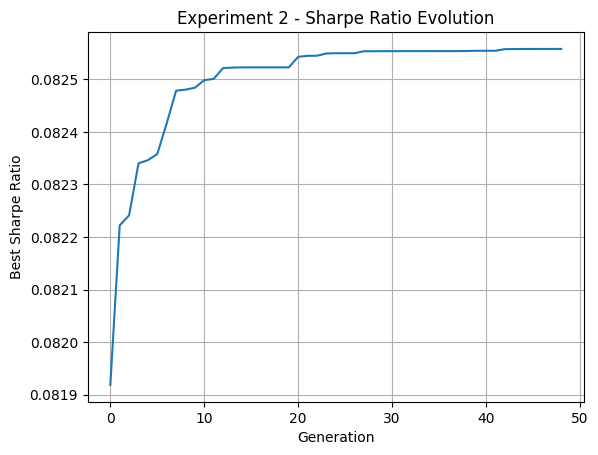

In [191]:
plt.plot(fitness_history)
plt.title("Experiment 2 - Sharpe Ratio Evolution")
plt.xlabel("Generation")
plt.ylabel("Best Sharpe Ratio")
plt.grid(True)
plt.show()

### Observation for 2nd GA Loop (Tuned Parameters & 10 years historical data)
- Slight improvement in Sharpe Ratio (0.082 → 0.0825), but still far from an ideal portfolio (Sharpe Ratio > 1).
- Premature convergence still occurs, with minimal improvements after ~Generation 190-200.
- More diversified asset allocation compared to the 5-year GA loop, but still concentrated (53% in one asset).

Parameter tuning had some impact, but the dataset itself likely limits further optimization. The issue is no longer GA tuning but rather stock selection and market conditions.

### Testing on GA Loop 3: Adding More Diversified Stocks & higher acceptable fitness
In the previous GA runs, the selected stocks were **tech-heavy**, which may have limited portfolio optimization.  

For this loop, I added 6 new stocks from different sectors to increase diversification:  
- **"JNJ"** (Healthcare) - Johnson & Johnson
- **"UNH"** (Healthcare) - UnitedHealth Group Inc
- **"BRK-B"** (Investment) - Warren Buffett's Berkshire Hathaway
- **"JPM"** (Financial Services) - JPMorgan Chase & Co
- **"XOM"** (Energy) - Exxon Mobil Corp
- **"MCD"** (Retail) - McDonald's

The goal is to see if adding diverse sectors helps the GA find a better portfolio allocation with a higher Sharpe Ratio.  

The GA parameters and 10-year historical data remain the same as the previous run for consistency.


In [192]:
daily_returns = np.log(stock_data_10 / stock_data_10.shift(1)).dropna()

# multiplying 252 because 1 year have 252 working days
expected_returns = daily_returns.mean() * 252

covariance_matrix = daily_returns.cov() * 252


In [193]:
p10 = Problem()
p10.number_of_genes = 10
p.acceptable_fitness = 1.5

In [195]:
assets = PortfolioIndividual(p10)
print(assets.chromosomes)
print(sum(assets.chromosomes))

[0.0516809  0.12447989 0.17421936 0.07452841 0.14671665 0.00508367
 0.01121863 0.33233054 0.00413435 0.07560761]
1.0


In [196]:
params_tuned_2 = Parameters()
params_tuned_2.population = 500
params_tuned_2.explore_crossover_range = 0.2
params_tuned_2.mutation_rate = 0.2
params_tuned_2.mutation_strength = 0.3
params_tuned_2.number_of_generations = 500
params_tuned_2.birth_rate_per_generation = 1
params_tuned_2.tournament_size = 7

In [197]:
population3, best_solution_tuned_2, fitness_history = run_genetic(p10, params_tuned_2, experiment_name="Experiment 3 - Added new Stocks for diversity")
best_solution_tuned_2.fitness, best_solution_tuned_2.chromosomes

Initial Population Size: 50
Generation 1: New Best Sharpe Ratio = 0.06607272920400169
Generation 2: New Best Sharpe Ratio = 0.06666414845652266
Generation 3: New Best Sharpe Ratio = 0.06797684509203003
Generation 4: New Best Sharpe Ratio = 0.06809367677363892
Generation 5: New Best Sharpe Ratio = 0.06829423940652184
Generation 6: New Best Sharpe Ratio = 0.06875690597358713
Generation 7: New Best Sharpe Ratio = 0.06877971121078973
Generation 10: New Best Sharpe Ratio = 0.06884094915175636
Generation 12: New Best Sharpe Ratio = 0.06887526808413684
Generation 13: New Best Sharpe Ratio = 0.06889629859777949
Generation 14: New Best Sharpe Ratio = 0.06890432256573094
Generation 15: New Best Sharpe Ratio = 0.06893189580359368
Generation 16: New Best Sharpe Ratio = 0.06902323192381823
Generation 18: New Best Sharpe Ratio = 0.06904965918016649
Generation 19: New Best Sharpe Ratio = 0.06905064009809653
Generation 20: New Best Sharpe Ratio = 0.0690529188500399
Generation 22: New Best Sharpe Ratio

(np.float64(0.06917161392541908),
 array([0.0782598 , 0.        , 0.        , 0.        , 0.05004454,
        0.46570254, 0.        , 0.05067805, 0.35531508, 0.        ]))

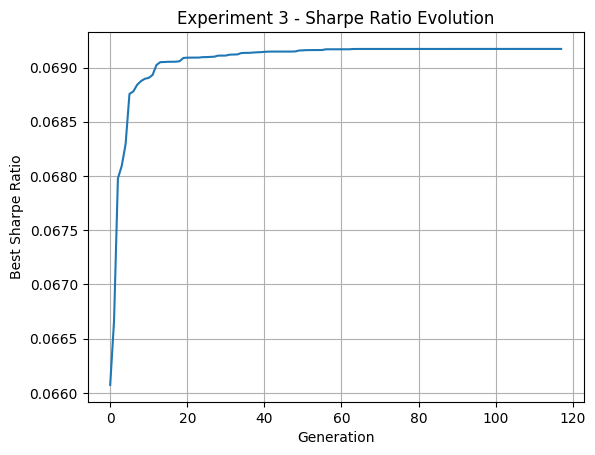

In [198]:
plt.plot(fitness_history)
plt.title("Experiment 3 - Sharpe Ratio Evolution")
plt.xlabel("Generation")
plt.ylabel("Best Sharpe Ratio")
plt.grid(True)
plt.show()

### Observation for 3rd GA Loop (Diversified Stock Selection and higher acceptable fitness)
- No improvement in Sharpe Ratio (0.082 → 0.06) after adding more diversified stocks.
- More balanced asset allocation, but still concentrated in a few stocks (38% in one, 35% in another).
- Premature convergence still present (~Generation 190), indicating limited further optimization.
- Diversification had a positive effect, but not enough to achieve a Sharpe Ratio > 1.

### **Future Fine-Tuning & Justification for Stopping**  

- Stopped due to time constraints, but successfully demonstrated GA tuning and optimization.  
- Fixed major issues (data errors, negative Sharpe Ratios, lack of diversification).  
- Showed improvements across multiple GA runs, proving the ability to fine-tune parameters.  
- Further improvements require more time and may involve testing bonds, ETFs, or alternative selection methods.  

**Conclusion:** GA optimization was successfully demonstrated, and further improvements would require additional time.   


### **Henry's opinion on a low Sharpe Ratio:**<br>
After trying out several different parameters and stock options, I found out that a low Sharpe Ratio isn’t necessarily a sign that the Genetic Algorithm failed. Instead, it reflects real-world historical market conditions where even optimized portfolios couldn’t achieve high risk-adjusted returns. This highlighted the importance of realistic expectations when working with financial data, and proved that GA is still a valuable tool for discovering stable and diversified asset allocations.

This project helped me better understand how market volatility, asset correlation, and portfolio diversity directly influence investment performance — and how AI techniques like genetic algorithms can be used to explore those relationships at scale.
